<a href="https://colab.research.google.com/github/armanhak/NLP/blob/main/Classification_Amazon_Reviews_Polarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<b>Еще недоделано 

In [ ]:
!pip install contractions
!pip install scikit-optimize

In [4]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (11, 6)
plt.rcParams.update({'font.size': 13})
import seaborn as sns
from wordcloud import WordCloud

import contractions
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
nltk.download("stopwords")
nltk.download('punkt')
nltk.download('wordnet')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,GridSearchCV, RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, accuracy_score,roc_auc_score
from sklearn.svm import LinearSVC
from skopt.space import Integer,Categorical, Real
from skopt.utils import use_named_args
from skopt import gp_minimize
import pickle

from tqdm import tqdm
import re
import sys 
RESULT = {'Model':[], 'ROC-AUC score':[]}

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [1]:
%cd /content/drive/MyDrive/nlp/lab1

/content/drive/MyDrive/nlp/lab1


# Download data

"Download data" выполняем один раз

In [ ]:
from torchtext.data.datasets_utils import (
    _RawTextIterableDataset,
    _wrap_split_argument,
    _add_docstring_header,
    _download_extract_validate,
    _create_dataset_directory,
    _create_data_from_csv,
)
import os 
import logging



In [ ]:
URL = 'https://drive.google.com/uc?export=download&id=0Bz8a_Dbh9QhbaW12WVVZS2drcnM'

MD5 = 'fe39f8b653cada45afd5792e0f0e8f9b'

NUM_LINES = {
    'train': 1,#3600000
    'test': 1,#400000
}
_PATH = 'amazon_review_polarity_csv.tar.gz'

_EXTRACTED_FILES = {
    'train': f'{os.sep}'.join(['amazon_review_polarity_csv', 'train.csv']),
    'test': f'{os.sep}'.join(['amazon_review_polarity_csv', 'test.csv']),
}

_EXTRACTED_FILES_MD5 = {
    'train': "520937107c39a2d1d1f66cd410e9ed9e",
    'test': "f4c8bded2ecbde5f996b675db6228f16"
}

DATASET_NAME = "AmazonReviewPolarity"


@_add_docstring_header(num_lines=NUM_LINES, num_classes=2)
@_create_dataset_directory(dataset_name=DATASET_NAME)
@_wrap_split_argument(('train', 'test'))
def AmazonReviewPolarity(root, split):
    path = _download_extract_validate(root, URL, MD5, os.path.join(root, _PATH), os.path.join(root, _EXTRACTED_FILES[split]),
                                      _EXTRACTED_FILES_MD5[split], hash_type="md5")
    logging.info('Creating {} data'.format(split))
    return _RawTextIterableDataset(DATASET_NAME, NUM_LINES[split],
                                   _create_data_from_csv(path))


In [ ]:
%%time
# d = AmazonReviewPolarity(r'/content/drive/MyDrive/nlp')
train = pd.read_csv('AmazonReviewPolarity/amazon_review_polarity_csv/train.csv',
                header=None,
                names =['label', 'title','text']
                )
test = pd.read_csv('AmazonReviewPolarity/amazon_review_polarity_csv/test.csv',
                header=None,
                names =['label', 'title','text']
                )
# 1 - negative, 2 - positive
train['label'] = train['label'].map({1:0, 2:1})
test['label'] = test['label'].map({1:0, 2:1})
print(f"""train: {train.shape}\ntest: {test.shape}""")


train: (3600000, 3)
test: (400000, 3)
CPU times: user 20.3 s, sys: 2.59 s, total: 22.9 s
Wall time: 1min 11s


Сохраним часть данных

In [ ]:
train = train.sample(100000,random_state=1234)
test = test.sample(11000, random_state=1234)
train.to_csv('data/train.csv', index=False)
test.to_csv('data/test.csv', index=False)

# Text cleaning

In [ ]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
print(f"""train: {train.shape}\ntest: {test.shape}""")
train.head()

train: (100000, 3)
test: (11000, 3)


,label,title,text
0,0,Horrible,Auto battle is a bore. I mean if everything is...
1,0,Decieving...,I was looking for a lifelike pug. The ad for t...
2,1,Loved it,I agree with Emperor Scott. This Live Album is...
3,1,A Cd worth a listen,This has some killa tracks like on the outside...
4,0,weight loss?,Not the miracle weight loss that Dr. Oz touted...


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   label   100000 non-null  int64 
 1   title   99997 non-null   object
 2   text    100000 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.3+ MB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000 entries, 0 to 10999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   11000 non-null  int64 
 1   title   11000 non-null  object
 2   text    11000 non-null  object
dtypes: int64(1), object(2)
memory usage: 257.9+ KB


Соединим title и text, после чего удалим title

In [ ]:
train['title'] = train['title'].fillna('')
train['text'] = train['title']+' '+train['text']
train.drop('title',axis=1, inplace=True)
test['text'] = test['title']+' '+test['text']
test.drop('title',axis=1, inplace=True)
train.head()

,label,text
0,0,Horrible Auto battle is a bore. I mean if ever...
1,0,Decieving... I was looking for a lifelike pug....
2,1,Loved it I agree with Emperor Scott. This Live...
3,1,A Cd worth a listen This has some killa tracks...
4,0,weight loss? Not the miracle weight loss that ...


приведем текст к нижнему регистру

In [ ]:
train['text'] = train['text'].map(str.lower)

используем пакет сокращений, чтобы расширить сокращения на английском языке, например<br>
we'll -> we will<br>
we shouldn't've -> we should not have.

In [ ]:
# Test
test_text = """
            Y'all can't expand contractions I'd think. I'd like to know how I'd done that! 
            We're going to the zoo and I don't think I'll be home for dinner.
            Theyre going to the zoo and she'll be home for dinner.
            We should've do it in here but we shouldn't've eat it
            """
print("Test: ", contractions.fix(test_text))

Test:  
            you all cannot expand contractions I would think. I would like to know how I would done that! 
            we are going to the zoo and I do not think I will be home for dinner.
            they are going to the zoo and she will be home for dinner.
            We should have do it in here but we should not have eat it
            


In [ ]:
train['text'] = train['text'].map(contractions.fix)

удалим ссылки, если их есть 

In [ ]:
def remove_url(text):
    """        Remove URLs from a string
    """
    return re.sub(r"https?://\S+|www\.\S+", "", text)

In [ ]:
train['text'] = train['text'].map(remove_url)

Удалим специальные символы. Ими могут быть смайлики или другие графические символы

In [ ]:
def remove_special_characters(text):
    """
        Remove special special characters, including symbols, emojis, and other graphic characters
    """
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [ ]:
train['text'] = train['text'].map(remove_special_characters)

исправим возможные опечатки, аббревиатуры 

In [ ]:
def other_clean(text):
        """
            Other manual text cleaning techniques
        """
        # Typos, slang and other
        sample_typos_slang = {
                                "w/e": "whatever",
                                "usagov": "usa government",
                                "recentlu": "recently",
                                "ph0tos": "photos",
                                "amirite": "am i right",
                                "exp0sed": "exposed",
                                "<3": "love",
                                "luv": "love",
                                "amageddon": "armageddon",
                                "trfc": "traffic",
                                "16yr": "16 year"
                                }

        # Acronyms
        sample_acronyms =  { 
                            "mh370": "malaysia airlines flight 370",
                            "okwx": "oklahoma city weather",
                            "arwx": "arkansas weather",    
                            "gawx": "georgia weather",  
                            "scwx": "south carolina weather",  
                            "cawx": "california weather",
                            "tnwx": "tennessee weather",
                            "azwx": "arizona weather",  
                            "alwx": "alabama weather",
                            "usnwsgov": "united states national weather service",
                            "2mw": "tomorrow"
                            }

        
        # Some common abbreviations 
        sample_abbr = {
                        "$" : " dollar ",
                        "€" : " euro ",
                        "4ao" : "for adults only",
                        "a.m" : "before midday",
                        "a3" : "anytime anywhere anyplace",
                        "aamof" : "as a matter of fact",
                        "acct" : "account",
                        "adih" : "another day in hell",
                        "afaic" : "as far as i am concerned",
                        "afaict" : "as far as i can tell",
                        "afaik" : "as far as i know",
                        "afair" : "as far as i remember",
                        "afk" : "away from keyboard",
                        "app" : "application",
                        "approx" : "approximately",
                        "apps" : "applications",
                        "asap" : "as soon as possible",
                        "asl" : "age, sex, location",
                        "atk" : "at the keyboard",
                        "ave." : "avenue",
                        "aymm" : "are you my mother",
                        "ayor" : "at your own risk", 
                        "b&b" : "bed and breakfast",
                        "b+b" : "bed and breakfast",
                        "b.c" : "before christ",
                        "b2b" : "business to business",
                        "b2c" : "business to customer",
                        "b4" : "before",
                        "b4n" : "bye for now",
                        "b@u" : "back at you",
                        "bae" : "before anyone else",
                        "bak" : "back at keyboard",
                        "bbbg" : "bye bye be good",
                        "bbc" : "british broadcasting corporation",
                        "bbias" : "be back in a second",
                        "bbl" : "be back later",
                        "bbs" : "be back soon",
                        "be4" : "before",
                        "bfn" : "bye for now",
                        "blvd" : "boulevard",
                        "bout" : "about",
                        "brb" : "be right back",
                        "bros" : "brothers",
                        "brt" : "be right there",
                        "bsaaw" : "big smile and a wink",
                        "btw" : "by the way",
                        "bwl" : "bursting with laughter",
                        "c/o" : "care of",
                        "cet" : "central european time",
                        "cf" : "compare",
                        "cia" : "central intelligence agency",
                        "csl" : "can not stop laughing",
                        "cu" : "see you",
                        "cul8r" : "see you later",
                        "cv" : "curriculum vitae",
                        "cwot" : "complete waste of time",
                        "cya" : "see you",
                        "cyt" : "see you tomorrow",
                        "dae" : "does anyone else",
                        "dbmib" : "do not bother me i am busy",
                        "diy" : "do it yourself",
                        "dm" : "direct message",
                        "dwh" : "during work hours",
                        "e123" : "easy as one two three",
                        "eet" : "eastern european time",
                        "eg" : "example",
                        "embm" : "early morning business meeting",
                        "encl" : "enclosed",
                        "encl." : "enclosed",
                        "etc" : "and so on",
                        "faq" : "frequently asked questions",
                        "fawc" : "for anyone who cares",
                        "fb" : "facebook",
                        "fc" : "fingers crossed",
                        "fig" : "figure",
                        "fimh" : "forever in my heart", 
                        "ft." : "feet",
                        "ft" : "featuring",
                        "ftl" : "for the loss",
                        "ftw" : "for the win",
                        "fwiw" : "for what it is worth",
                        "fyi" : "for your information",
                        "g9" : "genius",
                        "gahoy" : "get a hold of yourself",
                        "gal" : "get a life",
                        "gcse" : "general certificate of secondary education",
                        "gfn" : "gone for now",
                        "gg" : "good game",
                        "gl" : "good luck",
                        "glhf" : "good luck have fun",
                        "gmt" : "greenwich mean time",
                        "gmta" : "great minds think alike",
                        "gn" : "good night",
                        "g.o.a.t" : "greatest of all time",
                        "goat" : "greatest of all time",
                        "goi" : "get over it",
                        "gps" : "global positioning system",
                        "gr8" : "great",
                        "gratz" : "congratulations",
                        "gyal" : "girl",
                        "h&c" : "hot and cold",
                        "hp" : "horsepower",
                        "hr" : "hour",
                        "hrh" : "his royal highness",
                        "ht" : "height",
                        "ibrb" : "i will be right back",
                        "ic" : "i see",
                        "icq" : "i seek you",
                        "icymi" : "in case you missed it",
                        "idc" : "i do not care",
                        "idgadf" : "i do not give a damn fuck",
                        "idgaf" : "i do not give a fuck",
                        "idk" : "i do not know",
                        "ie" : "that is",
                        "i.e" : "that is",
                        "ifyp" : "i feel your pain",
                        "IG" : "instagram",
                        "iirc" : "if i remember correctly",
                        "ilu" : "i love you",
                        "ily" : "i love you",
                        "imho" : "in my humble opinion",
                        "imo" : "in my opinion",
                        "imu" : "i miss you",
                        "iow" : "in other words",
                        "irl" : "in real life",
                        "j4f" : "just for fun",
                        "jic" : "just in case",
                        "jk" : "just kidding",
                        "jsyk" : "just so you know",
                        "l8r" : "later",
                        "lb" : "pound",
                        "lbs" : "pounds",
                        "ldr" : "long distance relationship",
                        "lmao" : "laugh my ass off",
                        "lmfao" : "laugh my fucking ass off",
                        "lol" : "laughing out loud",
                        "ltd" : "limited",
                        "ltns" : "long time no see",
                        "m8" : "mate",
                        "mf" : "motherfucker",
                        "mfs" : "motherfuckers",
                        "mfw" : "my face when",
                        "mofo" : "motherfucker",
                        "mph" : "miles per hour",
                        "mr" : "mister",
                        "mrw" : "my reaction when",
                        "ms" : "miss",
                        "mte" : "my thoughts exactly",
                        "nagi" : "not a good idea",
                        "nbc" : "national broadcasting company",
                        "nbd" : "not big deal",
                        "nfs" : "not for sale",
                        "ngl" : "not going to lie",
                        "nhs" : "national health service",
                        "nrn" : "no reply necessary",
                        "nsfl" : "not safe for life",
                        "nsfw" : "not safe for work",
                        "nth" : "nice to have",
                        "nvr" : "never",
                        "nyc" : "new york city",
                        "oc" : "original content",
                        "og" : "original",
                        "ohp" : "overhead projector",
                        "oic" : "oh i see",
                        "omdb" : "over my dead body",
                        "omg" : "oh my god",
                        "omw" : "on my way",
                        "p.a" : "per annum",
                        "p.m" : "after midday",
                        "pm" : "prime minister",
                        "poc" : "people of color",
                        "pov" : "point of view",
                        "pp" : "pages",
                        "ppl" : "people",
                        "prw" : "parents are watching",
                        "ps" : "postscript",
                        "pt" : "point",
                        "ptb" : "please text back",
                        "pto" : "please turn over",
                        "qpsa" : "what happens", #"que pasa",
                        "ratchet" : "rude",
                        "rbtl" : "read between the lines",
                        "rlrt" : "real life retweet", 
                        "rofl" : "rolling on the floor laughing",
                        "roflol" : "rolling on the floor laughing out loud",
                        "rotflmao" : "rolling on the floor laughing my ass off",
                        "rt" : "retweet",
                        "ruok" : "are you ok",
                        "sfw" : "safe for work",
                        "sk8" : "skate",
                        "smh" : "shake my head",
                        "sq" : "square",
                        "srsly" : "seriously", 
                        "ssdd" : "same stuff different day",
                        "tbh" : "to be honest",
                        "tbs" : "tablespooful",
                        "tbsp" : "tablespooful",
                        "tfw" : "that feeling when",
                        "thks" : "thank you",
                        "tho" : "though",
                        "thx" : "thank you",
                        "tia" : "thanks in advance",
                        "til" : "today i learned",
                        "tl;dr" : "too long i did not read",
                        "tldr" : "too long i did not read",
                        "tmb" : "tweet me back",
                        "tntl" : "trying not to laugh",
                        "ttyl" : "talk to you later",
                        "u" : "you",
                        "u2" : "you too",
                        "u4e" : "yours for ever",
                        "utc" : "coordinated universal time",
                        "w/" : "with",
                        "w/o" : "without",
                        "w8" : "wait",
                        "wassup" : "what is up",
                        "wb" : "welcome back",
                        "wtf" : "what the fuck",
                        "wtg" : "way to go",
                        "wtpa" : "where the party at",
                        "wuf" : "where are you from",
                        "wuzup" : "what is up",
                        "wywh" : "wish you were here",
                        "yd" : "yard",
                        "ygtr" : "you got that right",
                        "ynk" : "you never know",
                        "zzz" : "sleeping bored and tired"
                        }
            
        sample_typos_slang_pattern = re.compile(r'(?<!\w)(' + '|'.join(re.escape(key) for key in sample_typos_slang.keys()) + r')(?!\w)')
        sample_acronyms_pattern = re.compile(r'(?<!\w)(' + '|'.join(re.escape(key) for key in sample_acronyms.keys()) + r')(?!\w)')
        sample_abbr_pattern = re.compile(r'(?<!\w)(' + '|'.join(re.escape(key) for key in sample_abbr.keys()) + r')(?!\w)')
        
        text = sample_typos_slang_pattern.sub(lambda x: sample_typos_slang[x.group()], text)
        text = sample_acronyms_pattern.sub(lambda x: sample_acronyms[x.group()], text)
        text = sample_abbr_pattern.sub(lambda x: sample_abbr[x.group()], text)        
        return text

In [ ]:
train["text"] = train["text"].map(other_clean)

Удалим лишние пробелы, знаки пунктуации и числовые символы

In [ ]:
import string
def remove_symbols(text):
    remove__symbols =  string.punctuation+string.digits
    t = text.translate(str.maketrans('', '', remove__symbols))
    return t

In [ ]:
train['text'] = train['text'].map(remove_symbols)

Применим всю очистку на тестовых данных

In [ ]:
def clean_text(text):
    text = text.lower()
    text = contractions.fix(text)
    text = remove_special_characters(text)
    text = other_clean(text)
    text = remove_symbols(text)
    return text

In [ ]:
test['text'] = test['text'].map(clean_text)

In [ ]:
train.to_csv('data/train_clean.csv',index=False)
test.to_csv('data/test_clean.csv',index=False)

# Preprocessing 

In [6]:
train = pd.read_csv('data/train_clean.csv')
train.shape

(100000, 2)

## Tokenize

In [7]:
train['tokenized'] = train['text'].map(word_tokenize)
train.head()

,label,text,tokenized
0,0,horrible auto battle is a bore i mean if every...,"[horrible, auto, battle, is, a, bore, i, mean,..."
1,0,decieving i was looking for a lifelike pug the...,"[decieving, i, was, looking, for, a, lifelike,..."
2,1,loved it i agree with emperor scott this live ...,"[loved, it, i, agree, with, emperor, scott, th..."
3,1,a cd worth a listen this has some killa tracks...,"[a, cd, worth, a, listen, this, has, some, kil..."
4,0,weight loss not the miracle weight loss that d...,"[weight, loss, not, the, miracle, weight, loss..."


Посмотрим на статиску длины текстов

In [8]:
train['tokenized'].map(lambda x: len(x)).describe()

count    100000.000000
mean         79.095040
std          43.146798
min           4.000000
25%          43.000000
50%          70.000000
75%         109.000000
max         213.000000
Name: tokenized, dtype: float64

In [8]:
train.head()

,label,text,tokenized
0,0,horrible auto battle is a bore i mean if every...,"[horrible, auto, battle, is, a, bore, i, mean,..."
1,0,decieving i was looking for a lifelike pug the...,"[decieving, i, was, looking, for, a, lifelike,..."
2,1,loved it i agree with emperor scott this live ...,"[loved, it, i, agree, with, emperor, scott, th..."
3,1,a cd worth a listen this has some killa tracks...,"[a, cd, worth, a, listen, this, has, some, kil..."
4,0,weight loss not the miracle weight loss that d...,"[weight, loss, not, the, miracle, weight, loss..."


## Remove stop-words

Удалим стоп слова. Из списка стоп слов убираем слова с отрицательными значениями.<br>
Также удалим токены с длиной меньше или ровно 2

In [9]:
stop = set(stopwords.words('english'))
stop = set(map(contractions.fix, stop))
not_stop = set([x for x in stop if 'not'  in x])
stop  = stop.difference(not_stop)
train['tokenized'] = train['tokenized'].map(lambda x: [word for word in x if word not in stop])
train['tokenized'] = train['tokenized'].map(lambda x: [word for word in x if len(word)>2])

In [10]:
train['tokenized'].map(lambda x: len(x)).describe()

count    100000.000000
mean         39.924460
std          21.625319
min           3.000000
25%          22.000000
50%          35.000000
75%          55.000000
max         138.000000
Name: tokenized, dtype: float64

## Лемматизация

In [11]:
lemmatizer = WordNetLemmatizer()
train['tokenized'] = train['tokenized'].map(lambda word_list: list(map(lemmatizer.lemmatize, word_list)))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## WordCloud

In [12]:
positive_text = ' '.join(train.loc[train['label']==1, 'tokenized'].map(lambda x: ' '.join(x)).values)
negative_text = ' '.join(train.loc[train['label']==0, 'tokenized'].map(lambda x: ' '.join(x)).values)

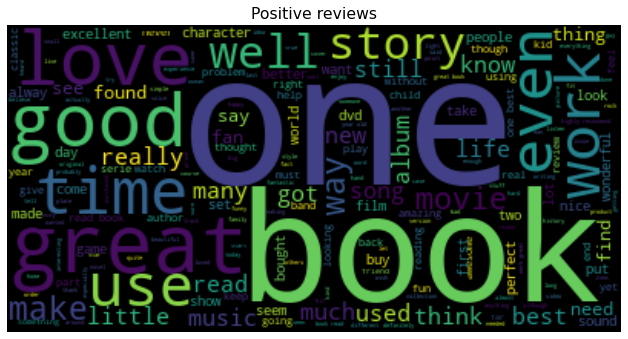

In [13]:
from wordcloud import WordCloud, ImageColorGenerator
# # Create and generate a word cloud image:
wordcloud = WordCloud().generate(positive_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Positive reviews')
plt.axis("off")
plt.show()

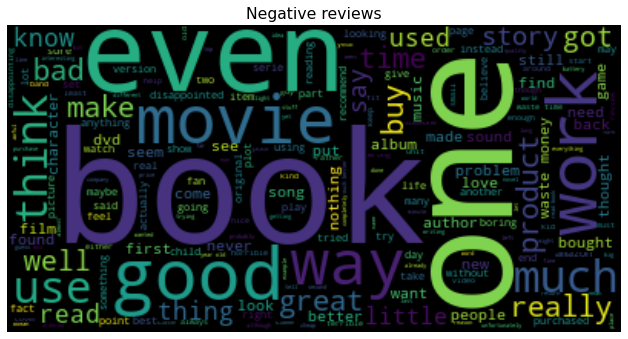

In [14]:
wordcloud = WordCloud().generate(negative_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Negative reviews')
plt.axis("off")
plt.show()

In [15]:
del negative_text, positive_text

# Features Extraction

In [16]:
train['clean_text'] = train['tokenized'].map(lambda x:' '.join(x))
train['word_count'] = train['tokenized'].map(lambda x: len(x))

объединим все этапы обработки, применим к контрольной тестовой выборке и сохраним

In [48]:
def clean(text):
    text = word_tokenize(text)
    stop = set(stopwords.words('english'))
    stop = set(map(contractions.fix, stop))
    not_stop = set([x for x in stop if 'not'  in x])
    stop  = stop.difference(not_stop)
    text = [word for word in text if word not in stop]
    text = [word for word in text if len(word)>2]
    text = list(map(WordNetLemmatizer().lemmatize, text))
    text = ' '.join(text)
    return text
test = pd.read_csv('data/test_clean.csv')
test['clean_text'] = test['text'].map(clean)

In [52]:
train[['label','text', 'clean_text']].to_csv('data/train_clean.csv',index=False)
test[['label','text', 'clean_text']].to_csv('data/test_clean.csv',index=False)

Посмотрим на распределение кол-ва слов. В большинстве случаев отзывы состоят где-то от 15 - 40 слов

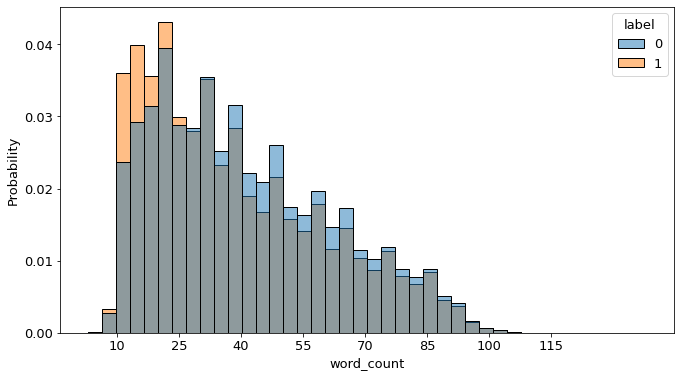

In [93]:
sns.histplot(x ='word_count', hue = 'label', data =train ,bins=40,stat = 'probability' )
plt.xticks(range(10,130,15))
pass

Выведем топ 15 слов из двух классов

In [94]:
counted_positive_words = collections.Counter(np.hstack(train.loc[train['label']==1, 'tokenized']).tolist())
counted_negative_words = collections.Counter(np.hstack(train.loc[train['label']==0, 'tokenized']).tolist())
word_count = {'label':[], 'words':[], 'counts':[]}
for letter, count in counted_positive_words.most_common(15):
    word_count['words'].append(letter)
    word_count['counts'].append(count)
    word_count['label'].append(1)
for letter, count in counted_negative_words.most_common(15):
    word_count['words'].append(letter)
    word_count['counts'].append(count)
    word_count['label'].append(0)
word_count = pd.DataFrame(word_count)


Из графиков видно, что наиболее часто в двух классах встречаются слова not, book, good и т.д.<br> 
То есть много общих слов для обих классов, дальше попробуем посмотреть на топ биграмов

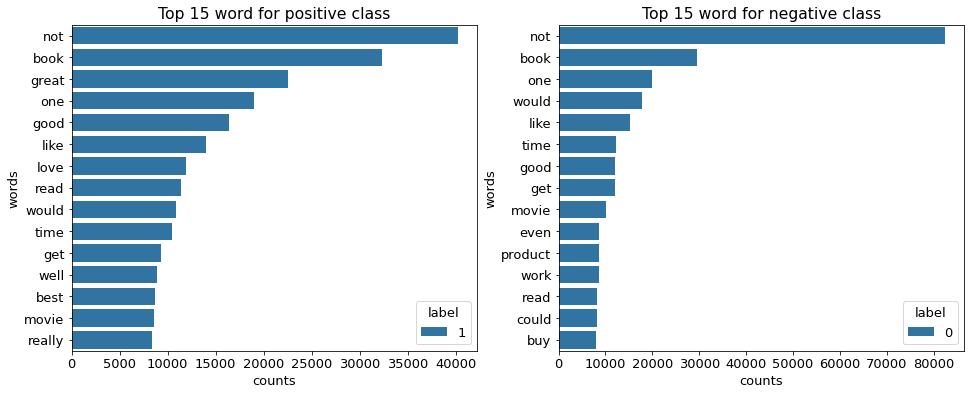

In [95]:
plt.figure(figsize=(16,6))
plt.subplot(121)
plt.title('Top 15 word for positive class')
sns.barplot(x = 'counts', y = 'words', data = word_count.loc[word_count['label'] ==1], hue='label')
plt.subplot(122)
plt.title('Top 15 word for negative class')

sns.barplot(x = 'counts', y = 'words', data = word_count.loc[word_count['label'] ==0], hue='label')
pass

In [123]:
from nltk import ngrams

negative_bisgrams = list(ngrams(np.hstack(train.loc[train['label']==0, 'tokenized']).tolist(), 2))
negative_bisgrams = list(map(lambda x: ' '.join(x), negative_bisgrams))

positive_bisgrams = list(ngrams(np.hstack(train.loc[train['label']==1, 'tokenized']).tolist(), 2))
positive_bisgrams = list(map(lambda x: ' '.join(x), positive_bisgrams))

In [124]:
counted_positive_words = collections.Counter(positive_bisgrams)
counted_negative_words = collections.Counter(negative_bisgrams)
word_count = {'label':[], 'words':[], 'counts':[]}
for letter, count in counted_positive_words.most_common(15):
    word_count['words'].append(letter)
    word_count['counts'].append(count)
    word_count['label'].append(1)
for letter, count in counted_negative_words.most_common(15):
    word_count['words'].append(letter)
    word_count['counts'].append(count)
    word_count['label'].append(0)
word_count = pd.DataFrame(word_count)

In [142]:
del positive_bisgrams,negative_bisgrams,counted_negative_words, counted_positive_words

Посмотрим на топ 15 биграмов. Уже что то понятно, два класса явно можно различить по по биграмам

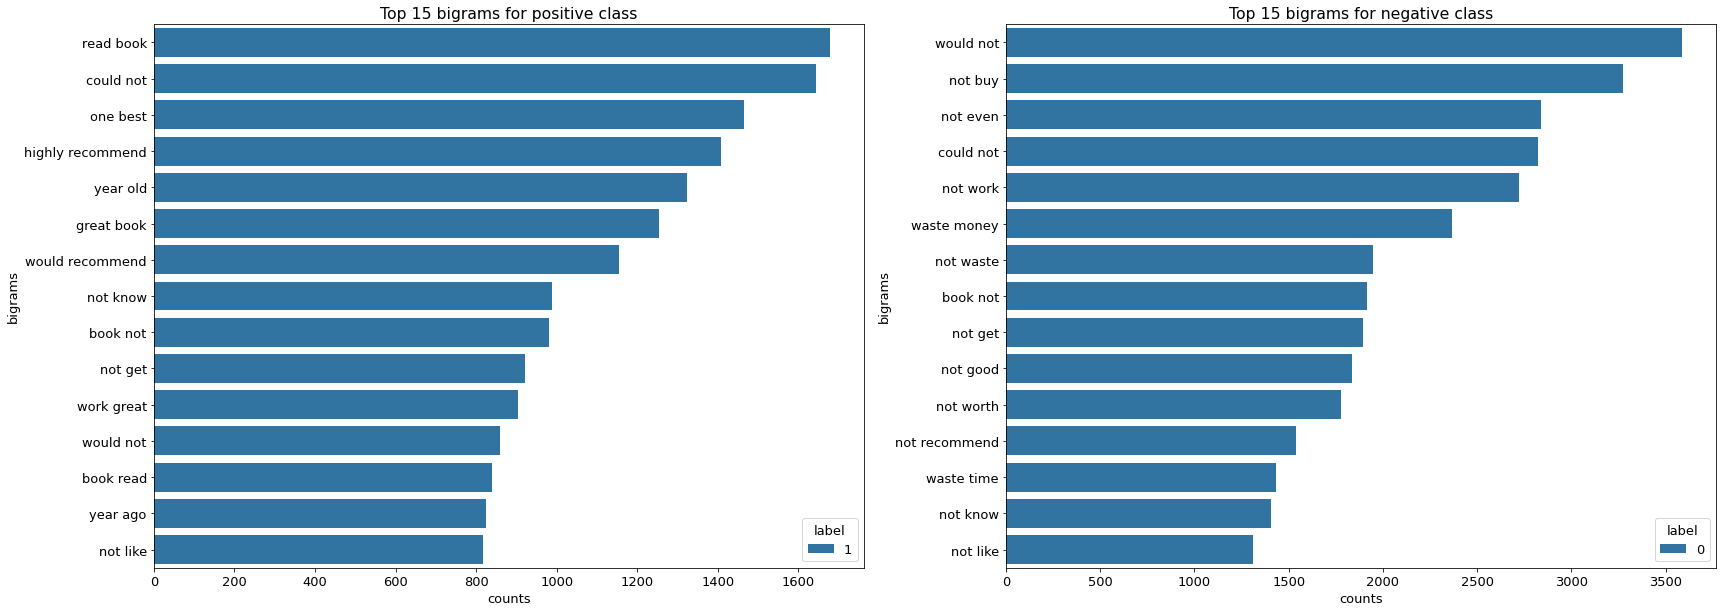

In [132]:
plt.figure(figsize=(28,10))
plt.subplot(121)
plt.title('Top 15 bigrams for positive class')
sns.barplot(x = 'counts', y = 'words', data = word_count.loc[word_count['label'] ==1], hue='label')
plt.ylabel('bigrams')

plt.subplot(122)
plt.title('Top 15 bigrams for negative class')

sns.barplot(x = 'counts', y = 'words', data = word_count.loc[word_count['label'] ==0], hue='label')
plt.ylabel('bigrams')
pass

В этой задачи применими TF-IDF векторизацию, так как для нас важны ключевые слова каждого класса, которые характерны для конкретного класса, и не важны слова (n-граммы), которые встречаются в обоих классов. Исходя из этого рассуждения tf-idf идеально подходит

## TF-IDF vectorizer

In [8]:
train  = pd.read_csv('data/train_clean.csv')
test =  pd.read_csv('data/test_clean.csv')

In [9]:
%%time
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    analyzer='word',
    ngram_range=(1, 3),
    max_features=5000
    )
word_vectorizer.fit(train['clean_text'])
train_word_features = word_vectorizer.transform(train['clean_text'])
test_word_features = word_vectorizer.transform(test['clean_text'])


CPU times: user 50.7 s, sys: 1.81 s, total: 52.5 s
Wall time: 52.5 s


Сохраним векторизатор

In [104]:
pickle.dump(word_vectorizer, open("models/vectorizer/tfidf_5000.pickle", "wb"))

## SVD

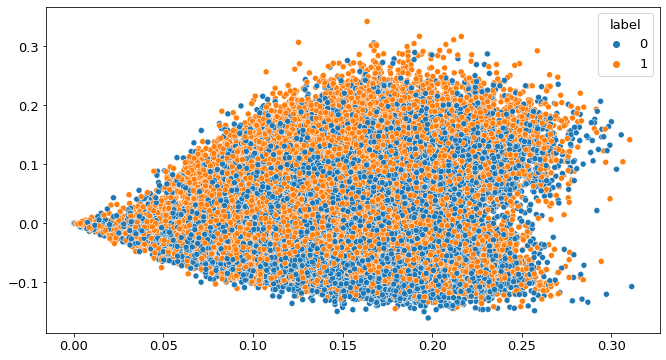

In [11]:
svd = TruncatedSVD(n_components = 2)
svd_data = svd.fit_transform(train_word_features)
sns.scatterplot(x = svd_data[:,0], y =svd_data[:,1],hue=train['label'] )
pass

In [12]:
%%time
svd = TruncatedSVD(500)
train_emb = svd.fit_transform(train_word_features)
test_emb = svd.transform(test_word_features)

CPU times: user 50.8 s, sys: 4.6 s, total: 55.4 s
Wall time: 41 s


In [105]:
pickle.dump(svd, open("models/decomposition/svd_500.pickle", "wb"))

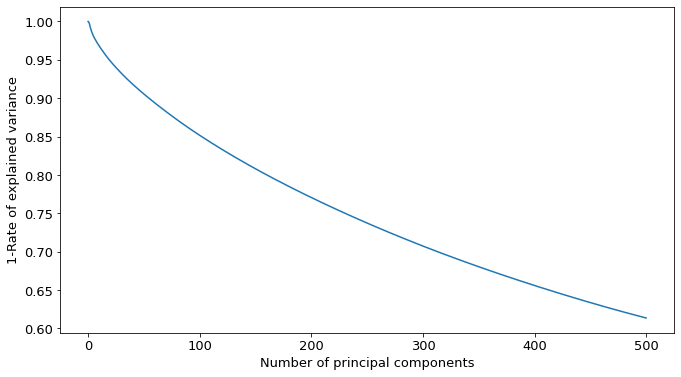

In [8]:
var_cumsum = np.cumsum(svd.explained_variance_ratio_)
plt.plot(range(0, 501), 1-np.append(0, var_cumsum))
plt.xlabel("Number of principal components")
plt.ylabel("1-Rate of explained variance")
plt.show()

# Machine learning

Посмотрим на распределению классов

Text(0.5, 1.0, 'train label')

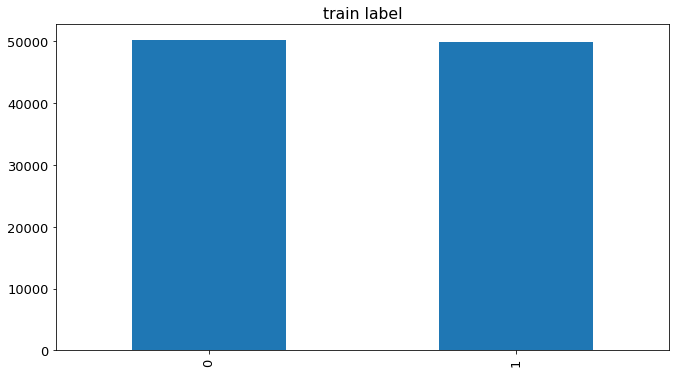

In [9]:
train['label'].value_counts().plot(kind= 'bar')
plt.title('train label')


Так как классы сбалансированы, в качестве метрики точности будем использовать accuracy

In [13]:
trainx,testx,trainy,testy = train_test_split(train_emb,
                                             train['label'],
                                             test_size = 0.15,
                                             stratify= train['label'],
                                            
                                             random_state = 8584)
print(f'trainx: {trainx.shape}\ntestx: {testx.shape}')


trainx: (85000, 500)
testx: (15000, 500)


In [11]:
trainy.value_counts()

0    42642
1    42358
Name: label, dtype: int64

## Logistic Regression

### Hyperparameter tuning. GridSearch

In [16]:
%%time
classifier = LogisticRegression(n_jobs=-1,solver = 'saga',random_state=3949)
params = {
    "C":np.logspace(-3,3,7),#обратная сила регулиризации
    "penalty":['elasticnet'],# l1-lasso, l2-ridge
    "l1_ratio":[0, 0.2, 0.3, 0.7,0.8, 1]# 0-is equivalent to using penalty='l2', 1-l1
    }   

rskf = RepeatedStratifiedKFold(n_splits=4, n_repeats=1,random_state=8473)
clf = GridSearchCV(classifier, params, cv=rskf, scoring='roc_auc')
clf.fit(trainx,trainy)

CPU times: user 1min 4s, sys: 39.2 s, total: 1min 43s
Wall time: 25min 14s


In [30]:
clf.best_params_

{'C': 10, 'l1_ratio': 0.7, 'penalty': 'elasticnet'}

In [17]:
clf = LogisticRegression(C=10,penalty = 'elasticnet',
                         l1_ratio = 0.7,
                         n_jobs=-1,solver = 'saga')
clf.fit(trainx,trainy)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=0.7, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='elasticnet',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [106]:
pickle.dump(clf, open("models/classification/logistic_regression.pickle", "wb"))

In [22]:
print(
f"""train roc-auc: {round(roc_auc_score(trainy, clf.predict(trainx)),2)}\n\
test roc-auc: {round(roc_auc_score(testy, clf.predict(testx)),2)}"""
)

train roc-auc: 0.88
test roc-auc: 0.88


Проверим точность на контрольной тестовой выборке и сохраним результаты в словарь

In [29]:
control_test_score = round(roc_auc_score(test['label'], clf.predict(test_emb)),2)
RESULT['Model'].append('LogistcRegresssion')
RESULT['ROC-AUC score'].append(control_test_score)
control_test_score

0.88

### Interpretation

Наверное было бы интересно посмотреть на коэфициенты модели логистической регрессии и попробовать вывести топ 20 слова из каждого компонента 

In [82]:
top_20_words_in_component = [[word_vectorizer.get_feature_names()[i]\
                             for i in comp.argsort()[::-1][:20]] \
                             for comp in svd.components_]
top_20_words_in_component = list(map(lambda x: ' | '.join(x), top_20_words_in_component))

In [98]:
feat_coef  = pd.DataFrame(zip(top_20_words_in_component, clf.coef_[0]),
                          columns=['top_20_words_in_component', 'component_coef'])
feat_coef = feat_coef.sort_values(by = 'component_coef',
                                  ascending=False)[['component_coef','top_20_words_in_component' ]]
pd.set_option('max_colwidth', 400)

Посмотрим на топ 20 слов (n-грамов) в компонентах, которые имели наибольший вес в модели

In [101]:
feat_coef.head(10)

,component_coef,top_20_words_in_component
2,17.373932,movie | album | song | music | love | best | like | fan | band | film | sound | track | favorite | story | rock | listen | ever | heard | great | voice
23,12.656236,well | worth | really | best | not | item | not worth | fit | price | read | album | amazon | worth money | year | made | nice | well worth | received | ordered | size
29,12.069528,music | much | read | one | time | know | better | want | item | find | much better | not | amazon | people | price | listen | read book | not know | buy | must
50,10.458975,excellent | fit | fan | sound | say | battery | film | bought | think | not fit | must | life | thing | book | size | story | perfect | first | use | big
15,9.505183,love | best | one | dvd | ever | work | buy | one best | show | not | well | like | fit | season | easy | series | not work | use | not buy | money
106,8.955997,fun | come | found | disappointed | people | must | real | picture | every | problem | awesome | old | month | put | loved | item | star | color | water | made
98,8.800113,video | life | looking | play | fun | many | perfect | review | toy | another | band | worth | come | something | long | real | keep | dog | think | awesome
34,8.459570,series | album | show | know | fan | season | quality | recommend | first | new | highly | well | must | watch | highly recommend | game | love | see | could | not know
41,8.415154,film | album | star | give | use | picture | child | day | excellent | quality | kid | fun | still | best | little | even | video | first | watch | see
196,8.391305,amazing | collection | enjoyed | anything | working | received | far | else | said | everything | would not | hold | hair | try | last | stopped | able | short | order | wanted


Посмотрим на топ 20 слов (n-грамов) компонентах, которые имели наименьший вес в модели

In [102]:
feat_coef.tail(10)

,component_coef,top_20_words_in_component
104,-6.566475,anyone | must | long | day | also | thought | fun | picture | problem | real | disappointed | part | fit | last | set | price | life | boring | used | character
63,-6.600149,watch | say | two | better | need | film | little | show | want | got | thing | set | new | easy | story | nothing | year | music | way | part
38,-7.073558,song | film | first | ever | bad | bought | show | look | worst | version | see | read | original | review | star | seen | picture | recommend | work | two
39,-7.832025,make | item | old | back | easy | show | fun | series | bad | received | worth | service | much | well | use | song | year old | season | not worth | day
55,-7.952448,say | think | want | fan | review | old | need | must | see | video | disappointed | back | better | something | year old | battery | reading | music | story | bought
33,-9.980290,music | well | first | series | get | best | use | sound | book | would | not | product | would not | character | season | show | disappointed | thought | month | little
37,-11.245309,bad | album | film | dvd | much | love | ever | worst | bought | great | not | music | made | look | review | recommend | worth | used | good | make
17,-11.271287,like | year | read | buy | one | work | old | great | story | sound | not like | not buy | really | year old | character | look | quality | not work | series | bad
3,-19.033014,movie | film | watch | dvd | waste | story | money | not | movie not | acting | character | see | seen | watching | plot | bad | waste money | not waste | funny | scene
4,-43.847123,not | money | waste | album | waste money | not waste | song | not waste money | buy | not buy | waste time | even | not even | bad | like | could | worst | band | music | time


Посмотрев на данные можно заметить, что компоненты с минимальными всеами содержат  отрицательные слова (n-граммы). А именно **bad**, **waste money**, **not waste money**, **not buy**, **not like**. <br>
А компоненты с максимальными значениями коффициентов наоборот, **like, favorite, fan, great, well worth, worth money**, **much better** и т.д.

## LinearSVC

In [ ]:
train = pd.read_csv('data/train_clean.csv')
test = pd.read_csv('data/test_clean.csv')
with open('models/vectorizer/tfidf_5000.pickle', 'rb') as f:
    word_vectorizer = pickle.load(f)
with open('models/decomposition/svd_500.pickle', 'rb') as f:
    svd = pickle.load(f)    


In [ ]:
%%time
train_word_features = word_vectorizer.transform(train['clean_text'])
test_word_features = word_vectorizer.transform(test['clean_text'])
train_emb = svd.fit_transform(train_word_features)
test_emb = svd.transform(test_word_features)

CPU times: user 1min 7s, sys: 5.31 s, total: 1min 12s
Wall time: 56.8 s


In [ ]:
trainx,testx,trainy,testy = train_test_split(train_emb,
                                             train['label'],
                                             test_size = 0.15,
                                             stratify= train['label'],
                                            
                                             random_state = 8584)
print(f'trainx: {trainx.shape}\ntestx: {testx.shape}')

trainx: (85000, 500)
testx: (15000, 500)


### Hyperparameter tuning. Bayesian optimization

In [ ]:
%%time
from sklearn.preprocessing import scale

# define the space of hyperparameters to search
search_space = [
                Real(1e-1, 1.5e3 ,name='C'), 
                Integer(500,1500, name = 'max_iter'), 
				Real(1e-5, 1e-1, name='tol'),
                Categorical(categories=['l1', 'l2'], name='penalty', transform='string'),

                ]

# define the function used to evaluate a given configuration
@use_named_args(search_space)
def evaluate_model(**params):
	model = LinearSVC(random_state=2343, dual=False)
	# something
	model.set_params(**params)
	# calculate 4-fold cross validation
	result = cross_val_score(model, trainx, trainy, cv=4, scoring='roc_auc')
	# calculate the mean of the scores
	estimate = np.mean(result)
	return 1.0 - estimate

# perform optimization
result = gp_minimize(evaluate_model,
                     search_space,
					 verbose=True,
					 n_jobs=-1,
					 n_calls=50)
# summarizing finding:
print(f'Best ROC-AUC: {(1.0 - result.fun)}')


Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 10.9995
Function value obtained: 0.0521
Current minimum: 0.0521
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 11.1161
Function value obtained: 0.0521
Current minimum: 0.0521
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 15.6909
Function value obtained: 0.0521
Current minimum: 0.0521
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 15.2177
Function value obtained: 0.0521
Current minimum: 0.0521
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 17.7710
Function value obtained: 0.0520
Current minimum: 0.0520
Iteration No: 6 started. Evalu

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 12.7343
Function value obtained: 0.0523
Current minimum: 0.0520
Iteration No: 24 started. Searching for the next optimal point.
Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 71.4911
Function value obtained: 0.0520
Current minimum: 0.0520
Iteration No: 25 started. Searching for the next optimal point.
Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 11.8603
Function value obtained: 0.0521
Current minimum: 0.0520
Iteration No: 26 started. Searching for the next optimal point.
Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 18.1977
Function value obtained: 0.0520
Current minimum: 0.0520
Iteration No: 27 started. Searching for the next optimal point.
Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 12.7596
Function value obtained: 0.0523
Current minimum: 0.0520
Iteration No: 28 started

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 26.6059
Function value obtained: 0.0520
Current minimum: 0.0520
Iteration No: 42 started. Searching for the next optimal point.
Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 13.0472
Function value obtained: 0.0523
Current minimum: 0.0520
Iteration No: 43 started. Searching for the next optimal point.
Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 11.1506
Function value obtained: 0.0521
Current minimum: 0.0520
Iteration No: 44 started. Searching for the next optimal point.
Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 27.1007
Function value obtained: 0.0520
Current minimum: 0.0520
Iteration No: 45 started. Searching for the next optimal point.
Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 40.3835
Function value obtained: 0.0520
Current minimum: 0.0520
Iteration No: 46 started

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 26.6273
Function value obtained: 0.0520
Current minimum: 0.0520
Best ROC-AUC: 0.9479751323838785
CPU times: user 20min 6s, sys: 43.2 s, total: 20min 49s
Wall time: 20min 7s


In [ ]:
best_params = {search_space[i].name:result.x[i] for i in range(len(search_space))}
best_params

{'C': 12.459298358922537,
 'max_iter': 1450,
 'penalty': 'l1',
 'tol': 0.0015875746823293525}

In [ ]:
clf = LinearSVC(random_state=2343,dual=False, **best_params)
clf.fit(trainx ,trainy)

LinearSVC(C=12.459298358922537, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
          max_iter=1450, multi_class='ovr', penalty='l1', random_state=2343,
          tol=0.0015875746823293525, verbose=0)

In [ ]:
print(f"""train roc-auc: {round(roc_auc_score(trainy, clf.predict(trainx)),2)}\n\
test roc-auc: {round(roc_auc_score(testy, clf.predict(testx)),2)}\n\
control test roc-auc: {round(roc_auc_score(test['label'], clf.predict(test_emb)),2)}
"""
)

train roc-auc: 0.88
test roc-auc: 0.88
control test roc-auc: 0.88



In [ ]:
RESULT['Model'].append('LinearSVC')
RESULT['ROC-AUC score'].append(round(roc_auc_score(test['label'], clf.predict(test_emb)),2))
pickle.dump(clf, open("models/classification/linear_svc.pickle", "wb"))

## RNN

In [5]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU,SimpleRNN
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
# from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping

In [7]:
train = pd.read_csv('data/train_clean.csv')
test = pd.read_csv('data/test_clean.csv')

trainx,validx,trainy,validy = train_test_split(train,
                                             train['label'],
                                             test_size = 0.15,
                                             stratify= train['label'],
                                            
                                             random_state = 8584)
print(f'trainx: {trainx.shape}\ntestx: {validx.shape}')

trainx: (85000, 3)
testx: (15000, 3)


In [8]:
%%time
# using keras tokenizer here
token = text.Tokenizer(num_words=None)
max_len = 1500

token.fit_on_texts(list(trainx['clean_text']) + list(validx['clean_text']))
xtrain_seq = token.texts_to_sequences(trainx['clean_text'])
xvalid_seq = token.texts_to_sequences(validx['clean_text'])

#zero pad the sequences
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len)
xvalid_pad = sequence.pad_sequences(xvalid_seq, maxlen=max_len)

word_index = token.word_index

CPU times: user 9.83 s, sys: 327 ms, total: 10.2 s
Wall time: 10 s


In [9]:
%%time
with strategy.scope():
    # A simpleRNN without any pretrained embeddings and one dense layer
    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                     300,
                     input_length=max_len))
    model.add(SimpleRNN(100))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1500, 300)         50704800  
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 100)               40100     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 50,745,001
Trainable params: 50,745,001
Non-trainable params: 0
_________________________________________________________________
CPU times: user 294 ms, sys: 43.1 ms, total: 337 ms
Wall time: 2.32 s


In [ ]:
%%time
model.fit(xtrain_pad, trainy, epochs=5, batch_size=64*strategy.num_replicas_in_sync) #Multiplying by Strategy to run on TPU's
